In [402]:
import os
import cv2
import numpy as np
from sklearn.utils import shuffle
from matplotlib import pyplot as plt

from keras import layers, Input, Model

plt.rcParams['figure.figsize'] = [15, 6]

In [307]:
IMAGE_SIZE = 128

BLANK_IMAGE = np.zeros((IMAGE_SIZE, IMAGE_SIZE, 3), np.uint8)
BLANK_IMAGE[:,:] = (255, 255, 255)

In [308]:
root = 'data/'
folders = [f.path for f in os.scandir(root) if f.is_dir()]

folders

['data/dogs',
 'data/cats',
 'data/bike',
 'data/flowers',
 'data/horses',
 'data/cars',
 'data/human']

In [309]:
def draw_random(images, labels = None):
      total = len(images)
    
      for local_index, global_index in enumerate(np.random.randint(0, total, 10)):
            image = images[global_index]
            label = global_index if labels is None else labels[global_index]
        
            plt.subplot(2, 5, local_index + 1)
            plt.imshow(image, cmap='gray', vmin=0, vmax=255)
            plt.axis(False)
            plt.title(label)

In [319]:
def resize_image(image):
    original_height, original_width = image.shape[:2]
    aspect = original_width / original_height

    width = IMAGE_SIZE
    height = IMAGE_SIZE
    height_offset = 0
    width_offset = 0

    if aspect > 1:
        height = int(np.round(IMAGE_SIZE / aspect))
        height_offset = int(np.round((IMAGE_SIZE - height) / 2))

    if aspect < 1:
        width = int(np.round(IMAGE_SIZE * aspect))
        width_offset = int(np.round((IMAGE_SIZE - width) / 2))

    image = cv2.resize(image, (width, height))
    
    if aspect == 1:
        return image
    
    new_image = BLANK_IMAGE.copy()
    new_image[height_offset:height_offset+height, width_offset:width_offset+width] = image.copy()

    return new_image

In [399]:
def load_images(folders = [], training = 0.8):
      images = []

      for folder in folders:
            fnames = os.listdir(folder)

            for fname in fnames:
                  original_image = cv2.imread(os.path.join(folder, fname))
                  original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
                  resized_image = resize_image(original_image)

                  images.append(resized_image)

      np.random.shuffle(images)
      
      total = len(images)
      offset = int(total * training)
      
      training_images = images[:offset]
      testing_images = images[offset:]
      
      return training_images, testing_images, total

In [400]:
training_images, testing_images, total = load_images(folders, training = 0.8)

len(training_images), len(testing_images), total

(1442, 361, 1803)

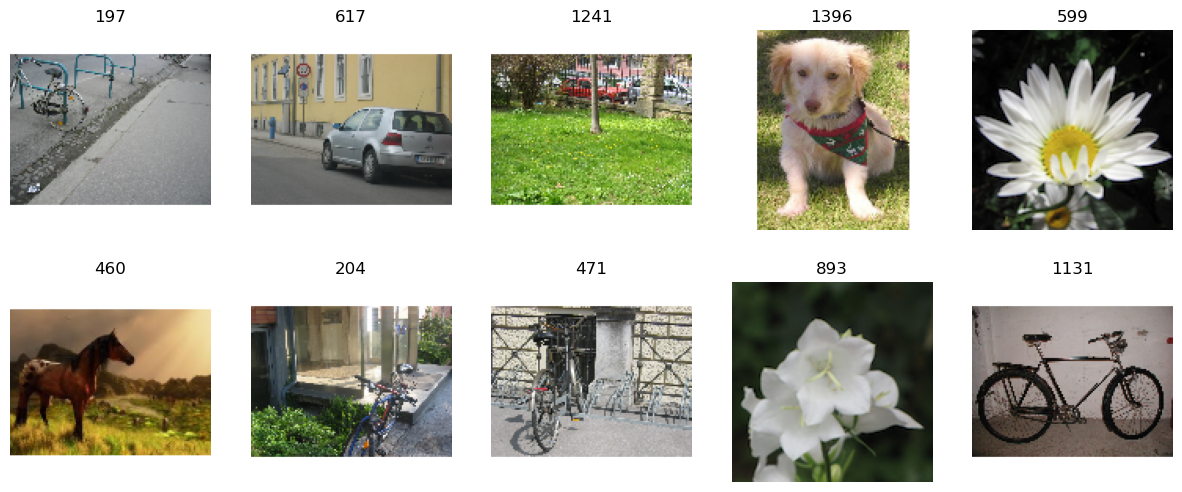

In [322]:
draw_random(training_images)

In [369]:
def gaussian_noise(image, mean = 0, stddev = 10, gamma = 1):
    gauss_noise = np.zeros(image.shape[:2])

    cv2.randn(gauss_noise, mean, stddev)

    gauss_noise = (gauss_noise * gamma).astype(np.uint8)
    
    merged = cv2.merge([gauss_noise] * 3)
    output = cv2.add(image, merged)

    return output

In [370]:
def salt_pepper_noise(image, prob = 0.5):
    output = image.copy()

    black = np.array([0, 0, 0], dtype='uint8')
    white = np.array([255, 255, 255], dtype='uint8')
    probs = np.random.random(output.shape[:2])

    output[probs < (prob / 2)] = black
    output[probs > 1 - (prob / 2)] = white

    return output

In [371]:
def uniform_noise(image, gamma = 1):
      uni_noise = np.zeros(image.shape[:2])
      cv2.randu(uni_noise, 0, 256)
      uni_noise = (uni_noise * gamma).astype(np.uint8)
      merged = cv2.merge([uni_noise, uni_noise, uni_noise])
      output = cv2.add(image, merged)
    
      return output

In [382]:
def add_noise_to_image(image):
    noise_type = np.random.randint(3) # 0: Gaussian, 1: Salt and Pepper, 2: Uniform
    
    if noise_type == 0:
        return gaussian_noise(image)
    
    if noise_type == 1:
        return salt_pepper_noise(image)
    
    return uniform_noise(image)

In [383]:
def add_noise_to_images(images):
    return [add_noise_to_image(image) for image in images]

In [384]:
noised_training_images = add_noise_to_images(training_images)

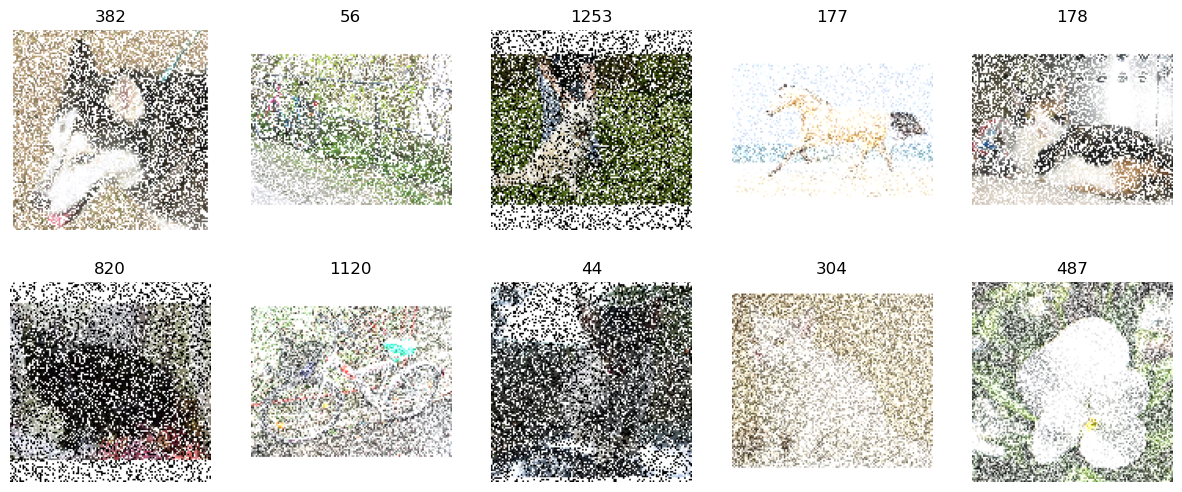

In [385]:
draw_random(noised_training_images)

In [386]:
def make_normalized_flattened(images):
      return np.array([image.flatten() for image in np.array(images)]) / 255

In [387]:
def make_data_for_model(noise_images, original_images):
      noise_images, original_images = shuffle(noise_images, original_images)
      noise_images = make_normalized_flattened(noise_images)
      original_images = make_normalized_flattened(original_images)

      return noise_images, original_images

In [390]:
noised_images_to_train, origin_images_to_train = make_data_for_model(noised_training_images, training_images)


len(noised_images_to_train), len(origin_images_to_train)

(1442, 1442)

In [392]:
noised_testing_images = add_noise_to_images(testing_images)

In [395]:
noised_images_to_test, origin_images_to_test = make_data_for_model(noised_testing_images, testing_images)


len(noised_images_to_test), len(origin_images_to_test)

(361, 361)

In [404]:
input = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 1))

x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(input)
x = layers.MaxPooling2D((2, 2), padding="same")(x)
x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(x)
x = layers.MaxPooling2D((2, 2), padding="same")(x)

x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2D(1, (3, 3), activation="sigmoid", padding="same")(x)

autoencoder = Model(input, x)
autoencoder.compile(optimizer="adam", loss="binary_crossentropy")
autoencoder.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 128, 128, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 128, 128, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 64, 64, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 64, 64, 32)     │         9,248 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_3              │ (None, 128, 128, 32)   │         9,248 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 128, 128, 1)    │           289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 28,353 (110.75 KB)

 Trainable params: 28,353 (110.75 KB)

 Non-trainable params: 0 (0.00 B)